In [1]:
%cd ..

import os
import torch
import torch.nn as nn
import torch.optim as optim
import copy

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import datasets

from alignment.alignment_utils import load_deep_jscc, get_batch_psnr
from alignment.alignment_model import _ConvolutionalAlignment, _LinearAlignment, AlignedDeepJSCC
from utils import image_normalization
import matplotlib.pyplot as plt

from dataset import Vanilla
from model import DeepJSCC
from tqdm import tqdm
import pickle

\\wsl.localhost\Ubuntu-24.04\home\lorenzo\repos\Deep-JSCC-PyTorch


In [2]:
model1_fp = r'alignment\models\upscaled_42.pkl'
model2_fp = r'alignment\models\upscaled_43.pkl'
saved = r'out\checkpoints\CIFAR10_8_7.0_0.17_AWGN_11h35m08s_on_Mar_27_2025\epoch_999.pkl'

snr = 7
times = 10

dataset = "imagenette"
resolution = 64

batch_size = 64
num_workers = 4
channel = 'AWGN'

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

# Init

## Data

In [ ]:
############
# GET DATA #
############

if dataset == 'cifar10':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.CIFAR10(root='../dataset/', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.CIFAR10(root='../dataset/', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenet':
    # the size of paper is 128
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    print("loading data of imagenet")

    train_dataset = datasets.ImageFolder(root='./dataset/ImageNet/train', transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = Vanilla(root='./dataset/ImageNet/val', transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

elif dataset == 'imagenette':
    transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((resolution, resolution))])

    train_dataset = datasets.Imagenette(root='../dataset/', split="train", download=True, transform=transform)
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

    test_dataset = datasets.Imagenette(root='../dataset/', split="val", download=True, transform=transform)
    test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers)

else:
    raise Exception('Unknown dataset')

  2%|▏         | 35.5M/1.56G [01:02<41:59, 604kB/s]  

In [4]:
class AlignmentDataset(Dataset):
    def __init__(self, dataloader, model1, model2, flat=False):
        self.outputs = []

        model1.eval()
        model1.to(device)

        model2.eval()
        model2.to(device)

        with torch.no_grad():
            for inputs, _ in tqdm(dataloader, desc="Computing model outputs"):
                inputs = inputs.to(device)

                out1 = model1(inputs)
                out2 = model2(inputs)

                for o1, o2 in zip(out1, out2):
                    if flat:
                        o1 = o1.flatten()
                        o2 = o2.flatten()

                    self.outputs.append((o1.cpu(), o2.cpu()))

    def __len__(self):
        return len(self.outputs)

    def __getitem__(self, idx):
        return self.outputs[idx]  

## Utils

In [5]:
def validation(model, dataloader, times):

    model = model.to(device)
    batch_psnr_list = []

    with torch.no_grad():
        for inputs, _ in dataloader:

            inputs = inputs.to(device)
            psnr = torch.zeros(size=(inputs.shape[0], ), device=device)

            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                gt = image_normalization('denormalization')(inputs)
                psnr += get_batch_psnr(demo_image, gt)

            psnr /= times
            batch_mean_psnr = psnr.mean().item()
            batch_psnr_list.append(batch_mean_psnr)

    overall_mean_psnr = sum(batch_psnr_list) / len(batch_psnr_list)

    return overall_mean_psnr

def load_from_checkpoint(path, snr):
    state_dict = torch.load(path, map_location=device)
    from collections import OrderedDict
    new_state_dict = OrderedDict()

    for k, v in state_dict.items():
        name = k.replace('module.','') # remove `module.`
        new_state_dict[name] = v

    file_name = os.path.basename(os.path.dirname(saved))
    c = file_name.split('_')[1]
    c = int(c)
    model = DeepJSCC(c=c, channel_type=channel, snr=snr)

    model.load_state_dict(new_state_dict)
    model.change_channel(channel, snr)

    return model

# Least Squares

## Train

In [8]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder


data = AlignmentDataset(train_loader, model1, model2, flat=True)

Computing model outputs:   0%|          | 0/148 [00:00<?, ?it/s]

Computing model outputs: 100%|██████████| 148/148 [01:13<00:00,  2.01it/s]


In [9]:
def dataset_to_matrices(dataset, batch_size=128):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    data_1 = []
    data_2 = []
    
    for batch in loader:
        data_1.append(batch[0])
        data_2.append(batch[1])

    return torch.cat(data_1, dim=0), torch.cat(data_2, dim=0)

matrix_1, matrix_2 = dataset_to_matrices(data)

In [10]:
#################
# LEAST SQUARES #
#################

Y = matrix_1.T
Z = matrix_2.T

Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

with open(r'alignment\models\aligner_64_imagenette.pkl', 'wb') as f:
    pickle.dump(Q, f)

## Validation

In [6]:
channel_type = 'AWGN'
model1_fp = r'alignment\models\seed42_v1.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'
aligner_fp = r'alignment\models\aligner_32.pkl'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
c = 8

model1 = load_deep_jscc(model1_fp, snr, c, channel_type)
model2 = load_deep_jscc(model2_fp, snr, c, channel_type)

with open(aligner_fp, 'rb') as f:
    align_matrix = pickle.load(f)

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)
aligner = _LinearAlignment(align_matrix)

aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel_type)
unaligned_model = AlignedDeepJSCC(encoder, decoder, None, snr, channel_type)

In [7]:
print(validation(model1, test_loader, times))
print(validation(unaligned_model, test_loader, times))
print(validation(aligned_model, test_loader, times))

22.738093528018634
10.387505458418731
27.894939070294615


## Plot

In [ ]:
def increasing_dataset_size():
    batch_size = 128
    n_batches = 782
    times = 10

    for b in range(1, n_batches+1):

        # dataset to matrices
        loader = DataLoader(data, batch_size=batch_size, shuffle=False)
        data_1 = []
        data_2 = []

        i = 0
        for batch in loader:
            data_1.append(batch[0])
            data_2.append(batch[1])
            i += 1

            if i == b:
                break

        matrix_1 = torch.cat(data_1, dim=0)
        matrix_2 = torch.cat(data_2, dim=0)

        # get model
        Y = matrix_1.T
        Z = matrix_2.T

        Q = Y @ Z.T @ torch.inverse(Z @ Z.T)

        with open(r'alignment\models\aligner.pkl', 'wb') as f:
            pickle.dump(Q, f)

        # load aligned model
        aligned_model = load_aligned_model(model1_fp, model2_fp, r'alignment\models\aligner.pkl', "linear" snr, c, channel)

        print(f"For {b} batches we get a PSNR of {validation(aligned_model, test_loader, times):.2f}")

In [43]:
increasing_dataset_size()

For 1 batches we get a PSNR of 5.22
For 2 batches we get a PSNR of 5.37
For 3 batches we get a PSNR of 5.15
For 4 batches we get a PSNR of 5.26
For 5 batches we get a PSNR of 5.38
For 6 batches we get a PSNR of 5.14
For 7 batches we get a PSNR of 5.36
For 8 batches we get a PSNR of 6.40
For 9 batches we get a PSNR of 18.09
For 10 batches we get a PSNR of 21.53
For 11 batches we get a PSNR of 23.44
For 12 batches we get a PSNR of 24.43
For 13 batches we get a PSNR of 25.09
For 14 batches we get a PSNR of 25.57
For 15 batches we get a PSNR of 25.88
For 16 batches we get a PSNR of 26.14
For 17 batches we get a PSNR of 26.33
For 18 batches we get a PSNR of 26.50
For 19 batches we get a PSNR of 26.63
For 20 batches we get a PSNR of 26.74
For 21 batches we get a PSNR of 26.84
For 22 batches we get a PSNR of 26.90
For 23 batches we get a PSNR of 26.97
For 24 batches we get a PSNR of 27.03
For 25 batches we get a PSNR of 27.08
For 26 batches we get a PSNR of 27.13
For 27 batches we get a PSNR 

KeyboardInterrupt: 

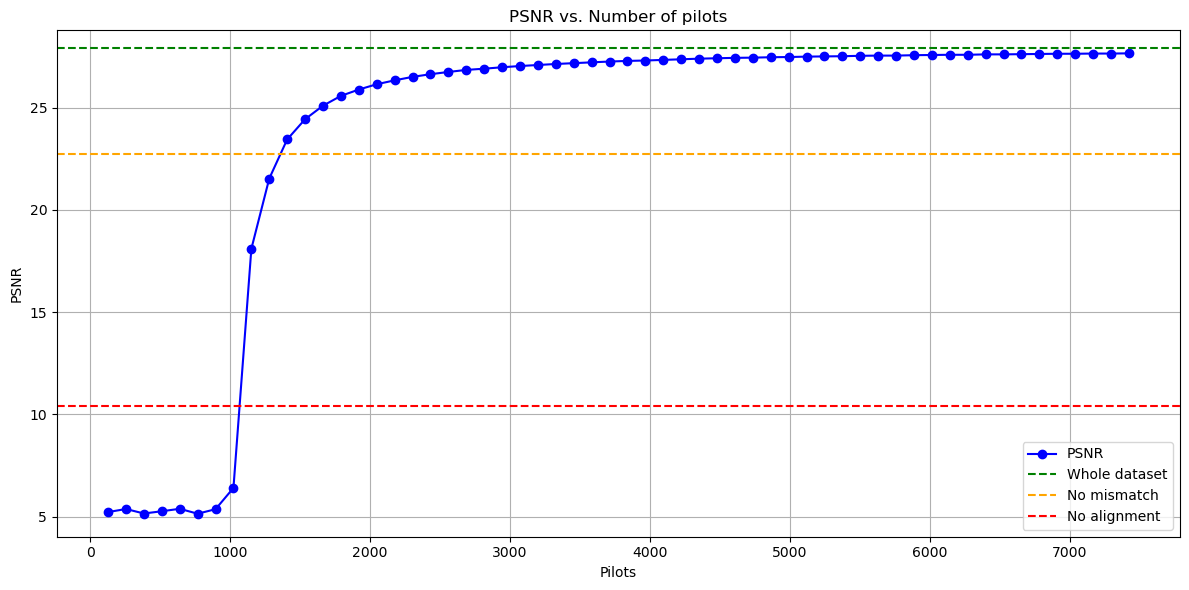

In [ ]:
psnr_values = [
    5.22, 5.37, 5.15, 5.26, 5.38, 5.14, 5.36, 6.40, 18.09, 21.53,
    23.44, 24.43, 25.09, 25.57, 25.88, 26.14, 26.33, 26.50, 26.63, 26.74,
    26.84, 26.90, 26.97, 27.03, 27.08, 27.13, 27.17, 27.21, 27.25, 27.28,
    27.30, 27.33, 27.36, 27.39, 27.41, 27.43, 27.44, 27.46, 27.47, 27.49,
    27.50, 27.51, 27.53, 27.54, 27.54, 27.56, 27.57, 27.58, 27.58, 27.60,
    27.60, 27.61, 27.62, 27.63, 27.63, 27.64, 27.64, 27.65
]

batches = list(range(1, len(psnr_values) + 1))

# Convert batches to number of elements (batch size = 128)
elements = [batch * 128 for batch in batches]

# Plotting with elements instead of batches
plt.figure(figsize=(12, 6))
plt.plot(elements, psnr_values, marker='o', linestyle='-', color='b', label='PSNR')

# Adding horizontal lines
plt.axhline(y=27.90, color='g', linestyle='--', linewidth=1.5, label='Whole dataset')
plt.axhline(y=22.74, color='orange', linestyle='--', linewidth=1.5, label='No mismatch')
plt.axhline(y=10.39, color='red', linestyle='--', linewidth=1.5, label='No alignment')

# Titles and labels
plt.title('PSNR vs. Number of pilots')
plt.xlabel('Pilots')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Convolutional

## Train

In [7]:
model1 = load_from_checkpoint(model1_fp, snr).encoder
model2 = load_from_checkpoint(model2_fp, snr).encoder

data = AlignmentDataset(train_loader, model1, model2, flat=False)
dataloader = DataLoader(data, batch_size=1024, shuffle=True)

Computing model outputs: 100%|██████████| 782/782 [00:36<00:00, 21.35it/s]


In [8]:
c = 8
epochs = 100

Da -20 a 30 con step di 10 (dB)

In [13]:
from channel import Channel

for snr in [-20, -10, 0, 10, 20, 30]:

    aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

    channel = Channel("AWGN", snr)
    print(f"Start SNR: {snr}")

    for epoch in range(epochs):
        for inputs, targets in dataloader:
            optimizer.zero_grad()

            #  add noise
            inputs = channel(inputs)

            outputs = aligner(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    with open(r'alignment\models\giugno\aligner_upscaled_noisy_'+str(snr)+'.pkl', 'wb') as f:
        pickle.dump(aligner, f)

Start SNR: -20
Epoch 1, Loss: 1.1382
Epoch 2, Loss: 0.9502
Epoch 3, Loss: 0.9494
Epoch 4, Loss: 0.9465
Epoch 5, Loss: 0.9444
Epoch 6, Loss: 0.9469
Epoch 7, Loss: 0.9464
Epoch 8, Loss: 0.9471
Epoch 9, Loss: 0.9464
Epoch 10, Loss: 0.9462
Epoch 11, Loss: 0.9469
Epoch 12, Loss: 0.9491
Epoch 13, Loss: 0.9461
Epoch 14, Loss: 0.9485
Epoch 15, Loss: 0.9471
Epoch 16, Loss: 0.9478
Epoch 17, Loss: 0.9468
Epoch 18, Loss: 0.9467
Epoch 19, Loss: 0.9459
Epoch 20, Loss: 0.9460
Epoch 21, Loss: 0.9468
Epoch 22, Loss: 0.9467
Epoch 23, Loss: 0.9477
Epoch 24, Loss: 0.9468
Epoch 25, Loss: 0.9475
Epoch 26, Loss: 0.9483
Epoch 27, Loss: 0.9488
Epoch 28, Loss: 0.9469
Epoch 29, Loss: 0.9473
Epoch 30, Loss: 0.9472
Epoch 31, Loss: 0.9484
Epoch 32, Loss: 0.9491
Epoch 33, Loss: 0.9457
Epoch 34, Loss: 0.9486
Epoch 35, Loss: 0.9470
Epoch 36, Loss: 0.9473
Epoch 37, Loss: 0.9474
Epoch 38, Loss: 0.9448
Epoch 39, Loss: 0.9463
Epoch 40, Loss: 0.9494
Epoch 41, Loss: 0.9475
Epoch 42, Loss: 0.9453
Epoch 43, Loss: 0.9481
Epoch

In [ ]:
for epoch in range(epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()

        # add noise to input

        outputs = aligner(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 0.9976
Epoch 2, Loss: 0.8271
Epoch 3, Loss: 0.7119
Epoch 4, Loss: 0.6321
Epoch 5, Loss: 0.5720
Epoch 6, Loss: 0.5371
Epoch 7, Loss: 0.4983
Epoch 8, Loss: 0.4646
Epoch 9, Loss: 0.4466
Epoch 10, Loss: 0.4267
Epoch 11, Loss: 0.4116
Epoch 12, Loss: 0.3968
Epoch 13, Loss: 0.3829
Epoch 14, Loss: 0.3700
Epoch 15, Loss: 0.3637
Epoch 16, Loss: 0.3551
Epoch 17, Loss: 0.3451
Epoch 18, Loss: 0.3410
Epoch 19, Loss: 0.3324
Epoch 20, Loss: 0.3289
Epoch 21, Loss: 0.3230
Epoch 22, Loss: 0.3183
Epoch 23, Loss: 0.3147
Epoch 24, Loss: 0.3123
Epoch 25, Loss: 0.3091
Epoch 26, Loss: 0.3050
Epoch 27, Loss: 0.3040
Epoch 28, Loss: 0.3002
Epoch 29, Loss: 0.2966
Epoch 30, Loss: 0.2969
Epoch 31, Loss: 0.2959
Epoch 32, Loss: 0.2941
Epoch 33, Loss: 0.2904
Epoch 34, Loss: 0.2889
Epoch 35, Loss: 0.2893
Epoch 36, Loss: 0.2852
Epoch 37, Loss: 0.2869
Epoch 38, Loss: 0.2862
Epoch 39, Loss: 0.2837
Epoch 40, Loss: 0.2818
Epoch 41, Loss: 0.2782
Epoch 42, Loss: 0.2786
Epoch 43, Loss: 0.2773
Epoch 44, Loss: 0.27

In [15]:
with open(r'alignment\models\aligner_conv_upscaled.pkl', 'wb') as f:
    pickle.dump(aligner, f)

## Validation

In [6]:
channel = 'AWGN'
model1_fp = r'alignment\models\seed42_v1.pkl'
model2_fp = r'alignment\models\seed43_v1.pkl'
aligner_fp = r'alignment\models\aligner_conv.pkl'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

snr = 7
times = 10
c = 8

model1 = load_deep_jscc(model1_fp, snr, c, channel)
unaligned_model = load_aligned_model(model1_fp, model2_fp, None, "linear", snr, c, channel)
aligned_model = load_aligned_model(model1_fp, model2_fp, aligner_fp, "conv", snr, c, channel)

In [7]:
print(validation(model1, test_loader, times))
print(validation(unaligned_model, test_loader, times))
print(validation(aligned_model, test_loader, times))

22.736292711488762
10.38290393732156
28.825688441088246


## Plot

In [8]:
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

In [9]:
import torch
import torch.multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def validation_worker(model, inputs, gt, times, worker_id):
    """Worker function for parallel model inference"""
    model.eval()
    psnr_sum = torch.zeros(inputs.shape[0], device=inputs.device)
    
    with torch.no_grad():
        for _ in range(times):
            demo_image = model(inputs)
            demo_image = image_normalization('denormalization')(demo_image)
            psnr_sum += get_batch_psnr(demo_image, gt)
    
    return psnr_sum / times

def validation_parallel_inference(model, dataloader, times, num_workers=None):
    """Version with parallel inference for multiple runs"""
    model = model.to(device)
    model.eval()
    
    # Auto-detect optimal number of workers
    if num_workers is None:
        num_workers = min(times, torch.cuda.device_count() if torch.cuda.is_available() else mp.cpu_count())
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                # No need for parallelization with single run
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Parallel inference for multiple runs
                runs_per_worker = times // num_workers
                remaining_runs = times % num_workers
                
                batch_psnr_sum = torch.zeros(batch_size, device=device)
                
                # Use thread pool for GPU parallelization (better for CUDA)
                with ThreadPoolExecutor(max_workers=num_workers) as executor:
                    futures = []
                    
                    # Submit jobs with different number of runs per worker
                    for i in range(num_workers):
                        worker_runs = runs_per_worker + (1 if i < remaining_runs else 0)
                        if worker_runs > 0:
                            future = executor.submit(
                                validation_worker, 
                                model, inputs, gt, worker_runs, i
                            )
                            futures.append(future)
                    
                    # Collect results
                    for future in futures:
                        batch_psnr_sum += future.result()
                
                batch_psnr = batch_psnr_sum.sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

def validation_parallel_batches(model, dataloader, times, num_workers=4):
    """Version with parallel batch processing"""
    model = model.to(device)
    model.eval()
    
    def process_batch(batch_data):
        inputs, *_ = batch_data
        inputs = inputs.to(device)
        batch_size = inputs.shape[0]
        
        # Denormalize ground truth once
        gt = image_normalization('denormalization')(inputs)
        
        # Accumulate PSNR across multiple runs
        batch_psnr_sum = torch.zeros(batch_size, device=device)
        
        with torch.no_grad():
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
        
        batch_mean_psnr = (batch_psnr_sum / times).sum().item()
        return batch_mean_psnr, batch_size
    
    # Process batches in parallel
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_batch, dataloader))
    
    total_psnr = sum(psnr for psnr, _ in results)
    total_samples = sum(samples for _, samples in results)
    
    return total_psnr / total_samples

def validation_vectorized(model, dataloader, times):
    """Vectorized version for maximum efficiency when memory allows"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            # Denormalize ground truth once
            gt = image_normalization('denormalization')(inputs)
            
            if times == 1:
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr = get_batch_psnr(demo_image, gt).sum().item()
            else:
                # Vectorized computation - process all runs at once
                # Repeat inputs for all runs
                inputs_repeated = inputs.repeat(times, 1, 1, 1)
                
                # Single forward pass for all runs
                demo_images = model(inputs_repeated)
                demo_images = image_normalization('denormalization')(demo_images)
                
                # Reshape to separate runs and batch dimension
                demo_images = demo_images.view(times, batch_size, *demo_images.shape[1:])
                gt_repeated = gt.unsqueeze(0).repeat(times, 1, 1, 1, 1)
                
                # Compute PSNR for all runs at once
                psnr_all_runs = torch.stack([
                    get_batch_psnr(demo_images[i], gt_repeated[i]) 
                    for i in range(times)
                ])
                
                # Average across runs and sum across batch
                batch_psnr = psnr_all_runs.mean(dim=0).sum().item()
            
            total_psnr += batch_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

# Main validation function with automatic method selection
def validation(model, dataloader, times, method='auto', num_workers=None):
    """
    Optimized validation with multiple parallelization strategies
    
    Args:
        model: The model to validate
        dataloader: Data loader for validation data
        times: Number of inference runs per sample
        method: 'auto', 'vectorized', 'parallel_inference', 'parallel_batches', or 'sequential'
        num_workers: Number of parallel workers (auto-detected if None)
    """
    
    if method == 'auto':
        # Auto-select best method based on conditions
        if times == 1:
            method = 'sequential'
        elif times <= 4 and torch.cuda.is_available():
            method = 'vectorized'  # Best for GPU with moderate times
        elif times > 4:
            method = 'parallel_inference'  # Best for many inference runs
        else:
            method = 'parallel_batches'  # Best for CPU or complex cases
    
    if method == 'vectorized':
        return validation_vectorized(model, dataloader, times)
    elif method == 'parallel_inference':
        return validation_parallel_inference(model, dataloader, times, num_workers)
    elif method == 'parallel_batches':
        return validation_parallel_batches(model, dataloader, times, num_workers)
    else:  # sequential
        return validation_sequential(model, dataloader, times)

def validation_sequential(model, dataloader, times):
    """Original optimized sequential version for comparison"""
    model = model.to(device)
    model.eval()
    
    total_psnr = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for inputs, *_ in dataloader:
            inputs = inputs.to(device)
            batch_size = inputs.shape[0]
            
            gt = image_normalization('denormalization')(inputs)
            batch_psnr_sum = torch.zeros(batch_size, device=device)
            
            for _ in range(times):
                demo_image = model(inputs)
                demo_image = image_normalization('denormalization')(demo_image)
                batch_psnr_sum += get_batch_psnr(demo_image, gt)
            
            batch_mean_psnr = (batch_psnr_sum / times).sum().item()
            total_psnr += batch_mean_psnr
            total_samples += batch_size
    
    return total_psnr / total_samples

In [10]:
import os

folder = r"D:\File\Repos\Deep-JSCC-PyTorch\alignment\incremental"
model1_fp = r'alignment\models\upscaled_42.pkl'
model2_fp = r'alignment\models\upscaled_43.pkl'
c = 8
times = 10

model1 = load_deep_jscc(model1_fp, snr, c, "AWGN")
model2 = load_deep_jscc(model2_fp, snr, c, "AWGN")

encoder = copy.deepcopy(model1.encoder)
decoder = copy.deepcopy(model2.decoder)

for i in range(1800+1, 50000+1):
    aligner_fp = os.path.join(folder, "aligner_"+str(i)+".pkl")

    with open(aligner_fp, 'rb') as f:
        aligner = pickle.load(f)

    # load aligned model
    aligned_model = AlignedDeepJSCC(encoder, decoder, aligner, snr, channel)

    # validate and print
    print(f"For {i} elements we get a PSNR of {validation_vectorized(aligned_model, test_loader, times):.2f}")

For 1222 elements we get a PSNR of 27.86
For 1223 elements we get a PSNR of 27.87
For 1224 elements we get a PSNR of 27.86
For 1225 elements we get a PSNR of 27.95
For 1226 elements we get a PSNR of 27.90
For 1227 elements we get a PSNR of 28.01
For 1228 elements we get a PSNR of 27.94
For 1229 elements we get a PSNR of 28.04
For 1230 elements we get a PSNR of 28.03
For 1231 elements we get a PSNR of 27.95
For 1232 elements we get a PSNR of 27.92
For 1233 elements we get a PSNR of 27.93
For 1234 elements we get a PSNR of 27.91
For 1235 elements we get a PSNR of 27.77
For 1236 elements we get a PSNR of 27.93
For 1237 elements we get a PSNR of 27.90
For 1238 elements we get a PSNR of 27.93
For 1239 elements we get a PSNR of 28.03
For 1240 elements we get a PSNR of 27.94
For 1241 elements we get a PSNR of 27.95
For 1242 elements we get a PSNR of 27.93
For 1243 elements we get a PSNR of 27.85
For 1244 elements we get a PSNR of 27.80
For 1245 elements we get a PSNR of 27.97
For 1246 element

KeyboardInterrupt: 

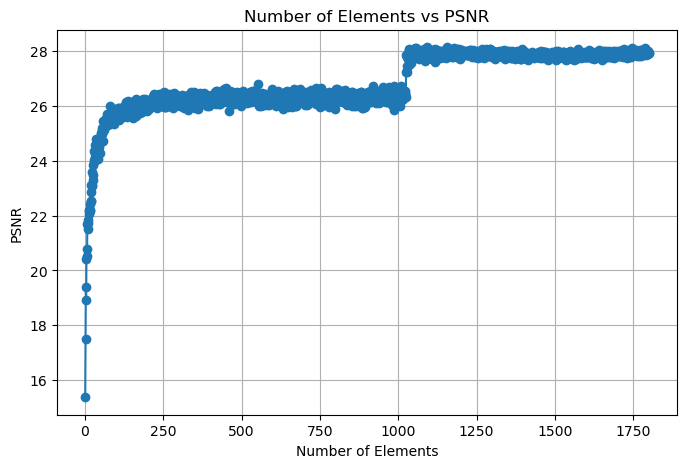

In [ ]:
import re
import matplotlib.pyplot as plt

# Read the text from the file
with open(r'D:\File\Repos\Deep-JSCC-PyTorch\alignment\models\log.txt', 'r') as file:
    text = file.read()

# Extract numbers using regex
elements = []
psnr = []

# Find all matches like "For X elements we get a PSNR of Y"
matches = re.findall(r'For (\d+) elements.*?PSNR of ([\d\.]+)', text)

for match in matches:
    elements.append(int(match[0]))
    psnr.append(float(match[1]))

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(elements, psnr, marker='o')
plt.title('Number of Elements vs PSNR')
plt.xlabel('Number of Elements')
plt.ylabel('PSNR')
plt.grid(True)
plt.show()

In [ ]:
def increasing_dataset_size():
    batch_size = 1024
    n_batches = 782
    times = 10
    c = 8
    granularity = 128
    model1 = load_from_checkpoint(model1_fp, snr).encoder
    model2 = load_from_checkpoint(model2_fp, snr).encoder

    subset_sizes = [i * granularity for i in range(1, n_batches + 1)]

    data = AlignmentDataset(train_loader, model1, model2, flat=False)

    for n in subset_sizes:
        # initialize dataset
        # indices = torch.randperm(len(data))[:n]
        indices = list(range(n))
        subset = Subset(data, indices)
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=True)

        # initialize aligner
        aligner = _ConvolutionalAlignment(in_channels=2*c, out_channels=2*c, kernel_size=5)
        epochs = 100
        criterion = nn.MSELoss()
        optimizer = optim.Adam(aligner.parameters(), lr=1e-3)

        # train aligner
        for epoch in range(epochs):
            for inputs, targets in dataloader:
                optimizer.zero_grad()
                outputs = aligner(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

        # save aligner
        with open(r'alignment\models\aligner.pkl', 'wb') as f:
            pickle.dump(aligner, f)

        # load aligned model
        aligned_model = AlignedDeepJSCC(model1_fp, model2_fp, r'alignment\models\aligner.pkl', "conv", snr, c, channel)

        # validate and print
        print(f"For {n} elements we get a PSNR of {validation(aligned_model, test_loader, times):.2f}")

In [22]:
increasing_dataset_size()

Computing model outputs: 100%|██████████| 782/782 [00:32<00:00, 24.04it/s]


For 128 elements we get a PSNR of 21.95
For 256 elements we get a PSNR of 22.40
For 384 elements we get a PSNR of 22.58
For 512 elements we get a PSNR of 22.37
For 640 elements we get a PSNR of 22.28
For 768 elements we get a PSNR of 22.21
For 896 elements we get a PSNR of 22.32
For 1024 elements we get a PSNR of 22.22
For 1152 elements we get a PSNR of 25.39
For 1280 elements we get a PSNR of 25.45
For 1408 elements we get a PSNR of 25.35
For 1536 elements we get a PSNR of 25.37
For 1664 elements we get a PSNR of 25.37
For 1792 elements we get a PSNR of 25.36
For 1920 elements we get a PSNR of 25.28
For 2048 elements we get a PSNR of 25.38
For 2176 elements we get a PSNR of 26.81
For 2304 elements we get a PSNR of 27.01
For 2432 elements we get a PSNR of 26.79
For 2560 elements we get a PSNR of 26.83
For 2688 elements we get a PSNR of 26.88
For 2816 elements we get a PSNR of 26.88
For 2944 elements we get a PSNR of 26.71
For 3072 elements we get a PSNR of 26.86
For 3200 elements we ge

KeyboardInterrupt: 

In [ ]:
"""
For 32 elements we get a PSNR of 20.96
For 64 elements we get a PSNR of 21.48
For 96 elements we get a PSNR of 21.94
For 128 elements we get a PSNR of 21.96
For 160 elements we get a PSNR of 22.06
For 192 elements we get a PSNR of 21.95
For 224 elements we get a PSNR of 21.77
For 256 elements we get a PSNR of 22.09
For 288 elements we get a PSNR of 22.49
For 320 elements we get a PSNR of 22.56
For 352 elements we get a PSNR of 22.21
For 384 elements we get a PSNR of 22.15
For 416 elements we get a PSNR of 22.08
For 448 elements we get a PSNR of 22.29
For 480 elements we get a PSNR of 22.62
For 512 elements we get a PSNR of 21.91
For 544 elements we get a PSNR of 22.28
For 576 elements we get a PSNR of 22.12
For 608 elements we get a PSNR of 22.50
For 640 elements we get a PSNR of 22.23
For 672 elements we get a PSNR of 22.13
For 704 elements we get a PSNR of 22.49
For 736 elements we get a PSNR of 22.20
For 768 elements we get a PSNR of 22.30
For 800 elements we get a PSNR of 22.06
For 832 elements we get a PSNR of 22.17
For 864 elements we get a PSNR of 22.42
For 896 elements we get a PSNR of 22.26
For 928 elements we get a PSNR of 22.40
For 960 elements we get a PSNR of 22.41
For 992 elements we get a PSNR of 21.85
For 1024 elements we get a PSNR of 22.06
For 1056 elements we get a PSNR of 25.61
For 1088 elements we get a PSNR of 25.39
For 1120 elements we get a PSNR of 25.30
For 1152 elements we get a PSNR of 25.36
For 1184 elements we get a PSNR of 25.59
For 1216 elements we get a PSNR of 25.38
For 1248 elements we get a PSNR of 25.36
For 1280 elements we get a PSNR of 25.50
For 1312 elements we get a PSNR of 25.49
For 1344 elements we get a PSNR of 25.49
For 1376 elements we get a PSNR of 25.37
For 1408 elements we get a PSNR of 25.41
For 1440 elements we get a PSNR of 25.18
For 1472 elements we get a PSNR of 25.30
For 1504 elements we get a PSNR of 25.44
For 1536 elements we get a PSNR of 25.25
For 1568 elements we get a PSNR of 25.36
For 1600 elements we get a PSNR of 25.07
For 1632 elements we get a PSNR of 25.58
For 1664 elements we get a PSNR of 25.30
For 1696 elements we get a PSNR of 25.35
For 1728 elements we get a PSNR of 25.45
For 1760 elements we get a PSNR of 25.44
For 1792 elements we get a PSNR of 25.26
For 1824 elements we get a PSNR of 25.33
For 1856 elements we get a PSNR of 25.21
For 1888 elements we get a PSNR of 25.32
For 1920 elements we get a PSNR of 25.34
For 1952 elements we get a PSNR of 25.59
For 1984 elements we get a PSNR of 25.51
"""

In [ ]:
"""
For 128 elements we get a PSNR of 21.95
For 256 elements we get a PSNR of 22.40
For 384 elements we get a PSNR of 22.58
For 512 elements we get a PSNR of 22.37
For 640 elements we get a PSNR of 22.28
For 768 elements we get a PSNR of 22.21
For 896 elements we get a PSNR of 22.32
For 1024 elements we get a PSNR of 22.22
For 1152 elements we get a PSNR of 25.39
For 1280 elements we get a PSNR of 25.45
For 1408 elements we get a PSNR of 25.35
For 1536 elements we get a PSNR of 25.37
For 1664 elements we get a PSNR of 25.37
For 1792 elements we get a PSNR of 25.36
For 1920 elements we get a PSNR of 25.28
For 2048 elements we get a PSNR of 25.38
For 2176 elements we get a PSNR of 26.81
For 2304 elements we get a PSNR of 27.01
For 2432 elements we get a PSNR of 26.79
For 2560 elements we get a PSNR of 26.83
For 2688 elements we get a PSNR of 26.88
For 2816 elements we get a PSNR of 26.88
For 2944 elements we get a PSNR of 26.71
For 3072 elements we get a PSNR of 26.86
For 3200 elements we get a PSNR of 27.68
For 3328 elements we get a PSNR of 27.61
For 3456 elements we get a PSNR of 27.75
For 3584 elements we get a PSNR of 27.69
For 3712 elements we get a PSNR of 27.67
For 3840 elements we get a PSNR of 27.60
For 3968 elements we get a PSNR of 27.76
For 4096 elements we get a PSNR of 27.69
For 4224 elements we get a PSNR of 28.05
For 4352 elements we get a PSNR of 28.08
For 4480 elements we get a PSNR of 28.05
For 4608 elements we get a PSNR of 28.05
For 4736 elements we get a PSNR of 28.16
For 4864 elements we get a PSNR of 28.11
For 4992 elements we get a PSNR of 28.14
For 5120 elements we get a PSNR of 28.10
For 5248 elements we get a PSNR of 28.38
For 5376 elements we get a PSNR of 28.33
For 5504 elements we get a PSNR of 28.42
For 5632 elements we get a PSNR of 28.32
For 5760 elements we get a PSNR of 28.40
For 5888 elements we get a PSNR of 28.45
For 6016 elements we get a PSNR of 28.31
For 6144 elements we get a PSNR of 28.42
For 6272 elements we get a PSNR of 28.55
For 6400 elements we get a PSNR of 28.56
For 6528 elements we get a PSNR of 28.50
For 6656 elements we get a PSNR of 28.56
For 6784 elements we get a PSNR of 28.57
For 6912 elements we get a PSNR of 28.56
For 7040 elements we get a PSNR of 28.52
For 7168 elements we get a PSNR of 28.56
For 7296 elements we get a PSNR of 28.68
For 7424 elements we get a PSNR of 28.64
For 7552 elements we get a PSNR of 28.67
For 7680 elements we get a PSNR of 28.65
For 7808 elements we get a PSNR of 28.68
For 7936 elements we get a PSNR of 28.69
For 8064 elements we get a PSNR of 28.65

"""

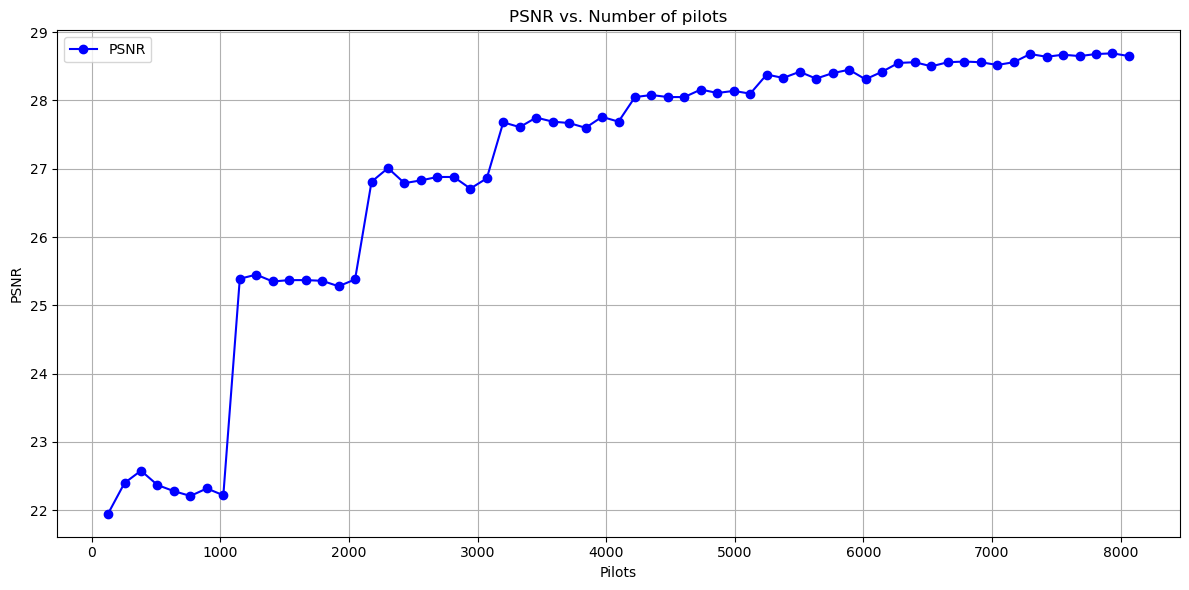

In [2]:
import matplotlib.pyplot as plt

elements = [
    128, 256, 384, 512, 640, 768, 896, 1024, 1152, 1280, 1408, 1536, 1664, 1792, 1920, 2048,
    2176, 2304, 2432, 2560, 2688, 2816, 2944, 3072, 3200, 3328, 3456, 3584, 3712, 3840, 3968, 4096,
    4224, 4352, 4480, 4608, 4736, 4864, 4992, 5120, 5248, 5376, 5504, 5632, 5760, 5888, 6016, 6144,
    6272, 6400, 6528, 6656, 6784, 6912, 7040, 7168, 7296, 7424, 7552, 7680, 7808, 7936, 8064
]

psnr_values = [
    21.95, 22.40, 22.58, 22.37, 22.28, 22.21, 22.32, 22.22, 25.39, 25.45, 25.35, 25.37, 25.37, 25.36, 25.28, 25.38,
    26.81, 27.01, 26.79, 26.83, 26.88, 26.88, 26.71, 26.86, 27.68, 27.61, 27.75, 27.69, 27.67, 27.60, 27.76, 27.69,
    28.05, 28.08, 28.05, 28.05, 28.16, 28.11, 28.14, 28.10, 28.38, 28.33, 28.42, 28.32, 28.40, 28.45, 28.31, 28.42,
    28.55, 28.56, 28.50, 28.56, 28.57, 28.56, 28.52, 28.56, 28.68, 28.64, 28.67, 28.65, 28.68, 28.69, 28.65
]

# Plotting with elements instead of elements
plt.figure(figsize=(12, 6))
plt.plot(elements, psnr_values, marker='o', linestyle='-', color='b', label='PSNR')

# Titles and labels
plt.title('PSNR vs. Number of pilots')
plt.xlabel('Pilots')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural

In [9]:
#############################
# LINEAR MODEL SGD TRAINING #
#############################

X = matrix_1
Y = matrix_2

# define linear model
model = nn.Linear(1024, 1024, bias=True)

# define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
num_epochs = 1000
for epoch, _ in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

# get the weight and bias
weights = model.weight.data   # shape: [1024, 1024]
bias = model.bias.data        # shape: [1024]

  0%|          | 0/1000 [00:00<?, ?it/s]


TypeError: cannot unpack non-iterable int object